In [1]:
import time
start_time = time.time()

In [2]:
import pandas as pd
import os
from bidi.algorithm import get_display
import re
import multiprocessing
import numpy as np

In [3]:
from scipy import sparse

In [25]:
import matplotlib.pyplot as plt

In [4]:
import pickle

In [5]:
file_type = 'thread'
field_name = 'title'

In [6]:
pickle_file = open(f'{file_type}_{field_name}_token_lists.pickle', "rb" )
corpus = pickle.load( pickle_file )
pickle_file.close()

In [7]:
corpus_temp = list()
for sentence in corpus:
    sentence_temp = list()
    for word in sentence:
        try:
            if len(word) > 1:
                sentence_temp.append(word)
        except:
            print(word)
    corpus_temp.append(' '.join(reversed(sentence_temp)))
corpus = corpus_temp

In [8]:
tf_idf_size = 1000

In [9]:
##Creating a list of stop words and adding custom stopwords
import codecs
with codecs.open('stopwords.txt', 'r', encoding='utf8') as f:
    text = f.read()
stop_words = set(word for word in text.split('\r\n'))

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=tf_idf_size)
X=cv.fit_transform(corpus)

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
tf_idf_vectors = tfidf_transformer.transform(X).todense()

In [12]:
tf_idf_vectors.shape

(23163, 1000)

In [13]:
from sklearn.cluster import DBSCAN

In [14]:
db = DBSCAN(eps=0.75, min_samples=10).fit(tf_idf_vectors)

In [15]:
labels = db.labels_

In [16]:
print(f'number of clusters are {len(set(labels)) - (1 if -1 in labels else 0)}')

number of clusters are 319


In [17]:
print(f'number of outliers {list(labels).count(-1)}')

number of outliers 8455


In [18]:
grouped_labels = dict()
for i in range(len(labels)):
    label = labels[i]
    if not label in grouped_labels:
        grouped_labels[label] = list()
    grouped_labels[label].append(tf_idf_vectors[i,])

In [19]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results


In [20]:
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [21]:
for label in grouped_labels:
    print(f'cluster label {label}')
    print(f'number of documents {len(grouped_labels[label])}')
    avg_vector = sparse.csr_matrix(np.average(grouped_labels[label],axis=0))
    print(extract_topn_from_vector(feature_names,sort_coo(avg_vector.tocoo())))

cluster label 0
number of documents 57
{'קורונה': 0.883, 'חיילים': 0.036, 'גיוס': 0.034, 'צו': 0.033, 'בסיס': 0.028, 'רץ': 0.023, 'גימלים': 0.02, 'מיון': 0.019, 'בידוד': 0.012, 'משרתים': 0.012}
cluster label 1
number of documents 6701
{'פטור': 0.033, 'גיבוש': 0.032, 'חיל': 0.03, 'צו': 0.027, 'תפקיד': 0.027, 'עזרה': 0.025, 'גיוס': 0.022, 'קורס': 0.022, 'טירונות': 0.021, 'מיונים': 0.02}
cluster label 2
number of documents 1947
{}
cluster label 3
number of documents 13
{'ביטחון': 0.909, 'מידע': 0.097, 'דעתכם': 0.051, 'אפשרי': 0.05, 'שק': 0.045}
cluster label -1
number of documents 8455
{'גיוס': 0.015, 'פרופיל': 0.013, 'תפקיד': 0.013, 'חיל': 0.012, 'קורס': 0.011, 'מיון': 0.011, 'קרבי': 0.01, 'שירות': 0.01, 'גיבוש': 0.009, 'מודיעין': 0.008}
cluster label 4
number of documents 16
{'חוקי': 0.896, 'תפקיד': 0.07, 'ביטחון': 0.043, 'עונש': 0.043, 'חוגר': 0.041, 'מפקד': 0.039, 'חיילת': 0.033, 'חיל': 0.018}
cluster label 5
number of documents 21
{'לוחמים': 0.886, 'מגב': 0.063, 'נשק': 0.056, 'פלחץ':

In [22]:
from sklearn.metrics import silhouette_score
silhouette_score(X, db.labels_, sample_size=1000)

-0.10451158375930672

In [23]:
silhouette_values = list()
limit=100; start=1; step=10;
for eps in range(start,limit,step):
    db_ = DBSCAN(eps=eps/100, min_samples=10).fit(tf_idf_vectors)
    silhouette_values.append(silhouette_score(X, db.labels_, sample_size=1000))

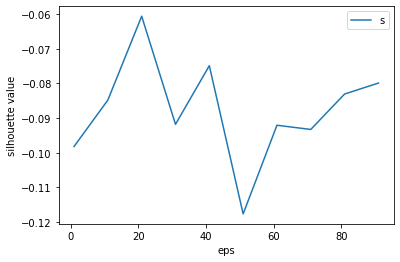

In [26]:
x = range(start, limit, step)
plt.plot(x, silhouette_values)
plt.xlabel("eps")
plt.ylabel("silhouette value")
plt.legend(("silhouette value"), loc='best')
plt.show()

In [42]:
def get_values_of_silhouette_from_vec_size_and_eps(vec_size_values, eps_values):
    silhouette_score_df = pd.DataFrame(columns=['vec_size','eps','nclusters','noutliers','silhouette_score'])
    for vec_size in vec_size_values:
        cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=vec_size)
        X=cv.fit_transform(corpus)
 
        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(X)
        # get feature names
        feature_names=cv.get_feature_names()
 
        # fetch document for which keywords needs to be extracted
        tf_idf_vectors = tfidf_transformer.transform(X).todense()
        for eps in eps_values:
            db = DBSCAN(eps=eps, min_samples=10).fit(tf_idf_vectors)
            labels = db.labels_
            nclusters = len(set(labels)) - (1 if -1 in labels else 0)
            noutliers = list(labels).count(-1)
            try:
                score = silhouette_score(X, db.labels_, sample_size=1000)
            except:
                score  = -1
            new_row_df = pd.DataFrame([[vec_size,eps,nclusters,noutliers,score]],columns=silhouette_score_df.columns)
            silhouette_score_df = silhouette_score_df.append(new_row_df , ignore_index=True)
    return silhouette_score_df
        #tf_idf_vectors.shape, print(f'number of clusters are {len(set(labels)) - (1 if -1 in labels else 0)}')
        #print(f'number of outliers {list(labels).count(-1)}')
        

In [43]:
pd_scores = get_values_of_silhouette_from_vec_size_and_eps([5,10], [0.5,1])
pd_scores.to_csv('cluster_preformace.csv')

,vec_size,eps,nclusters,noutliers,silhouette_score
0,5,0.5,9,20,0.979704
1,5,1.0,1,0,-1.000000
2,10,0.5,23,140,0.958604
3,10,1.0,1,0,-1.000000


In [ ]:
def send_email(user='dsakaidf@gmail.com', pwd='d54k4idf!', recipient='shkasta@post.bgu.ac.il',
               subject='finish expirement', body='finish the expirement'):
    import smtplib

    gmail_user = user
    gmail_pwd = pwd
    FROM = user
    TO = recipient if type(recipient) is list else [recipient]
    SUBJECT = subject
    TEXT = body

    # Prepare actual message
    message = """From: %s\nTo: %s\nSubject: %s\n\n%s
    """ % (FROM, ", ".join(TO), SUBJECT, TEXT)
    try:
        # SMTP_SSL Example
        server_ssl = smtplib.SMTP_SSL("smtp.gmail.com", 465)
        server_ssl.ehlo()  # optional, called by login()
        server_ssl.login(gmail_user, gmail_pwd)
        # ssl server doesn't support or need tls, so don't call server_ssl.starttls()
        server_ssl.sendmail(FROM, TO, message)
        # server_ssl.quit()
        server_ssl.close()
        print('successfully sent the mail')
    except:
        print("failed to send mail")


In [ ]:
send_email()

In [ ]:
elapsed_time = time.time() - start_time
print(elapsed_time)